# Exploratory Data Analysis

This notebook runs through a series of exploratory data analyses to assess the integrity and quality of the raw data.

## Installations

In [ ]:
! pip install ydata-profiling

In [ ]:
! pip install dataprep

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import json
from dataprofiler import Data, Profiler
from functools import reduce

# Set display of images in the notebook
%matplotlib notebook

# imputation libraries
from sklearn.impute import SimpleImputer, KNNImputer

# standardize variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# check versions
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

## Basic exploratory data approach

In [4]:
# Read data from csv and set data types (dtype), except the first column -'calldate'- which will be parsed later.
df = pd.read_csv("../data/raw_data.csv", sep=',', engine='python')

In [ ]:
# Inspect the dataframe
print(df.shape)
print(df.info())

In [ ]:
# If necessary, convert columns to str without spaces in lower case
df.columns = df.columns.str.replace('\s+', '_').str.lower()

#### Apply manual functions for data quality checks

In [ ]:
### analyze null values
def nullvalues(d):
    ''' Number of null values for each feature and 
        percentage of null values for each feature'''
    print("{:10s}|{:10s}|{:10s}".format("Feature",
                                        "Null values",
                                        "Null Values as a Proportion of Total"))
    print("="*100)
    for col in d.columns:
        null_values = d[col].isnull().sum(axis=0)
        null_values_pct = d[col].isnull().sum(axis=0)/len(d)*100
        print("{:10s}|{:10d}\t|{:10f}".format(str(col),
                                             null_values,
                                             null_values_pct))

### analyze cardinality
def cardinality(data):
    ''' Check number of unique values of variables
        not accounting for null values '''
    print("{:15s}\t| {:10s}\t| {:10s}".format("Feature",
                                              "Distinct Values",
                                              "Distinct Values as a Proportion of Total"))
    print("="*100)
    for col in data.columns[:]:
        unique_values = len(np.unique(data[col].ffill()))
        unique_values_pct = len(np.unique(data[col].ffill()))/len(data) 
        print("{:15s}\t| {:10d}\t\t| {:10f}".format(str(col),
                                                   unique_values,
                                                   unique_values_pct))

### analyze duplicates
def rowduplication(data):
    ''' Assess the number and percent of duplicates for entire rows in dataset '''
    data_dedup = data.drop_duplicates(keep='first')
    data_duplicates = data[data.duplicated(subset=None, keep='first')]
    
    print('Shape of de-duplicated dataset', data_dedup.shape)
    print('Number of duplicates:', len(data) - len(data_dedup))
    print('Confirm number of duplicates:', len(data_duplicates))

def duplicationanalyzer(data):
    ''' Assess the number and percentage of duplicates 
        for each variable in the dataset'''
    variable = pd.Series(np.nan)
    
    for var in data:
        ''' Output the number of duplicates and proportion of duplicates '''
        variable = data[var]
        
        # construct variable dataframe less duplicates
        variable_dedup = variable.drop_duplicates(keep='first')
        
        #print the number of duplicates
        duplicates=data[data[var].duplicated(keep=False)]
        print(var)
        print('Number of duplicates: ', len(duplicates))
        
        #print the percentage of duplicates
        percentage = "{0:.4f}".format(len(duplicates)/len(data))
        print('Percentage of duplicates: ', percentage)

In [ ]:
nullvalues(d=df)

In [ ]:
cardinality(data=df)

In [ ]:
rowduplication(data=df)

In [ ]:
duplicationanalyzer(data=df)

#### Explore summary statistics

In [12]:
# define functions for summary statistics on categorical and numeric variables

def catvardistribution(data, var, title):
    ''' Examine value counts and countplots'''
    %matplotlib inline
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    print(data[var].value_counts(dropna=False))
    sns.set(style='darkgrid')
    ax = sns.countplot(x=data[var], data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(title)
    plt.show()

def summarystats(data, var, titleplot, n_bins):
    ''' Print summary statistics, show histogram and boxplot '''
    %matplotlib inline
    print(data[var].unique())
    print(data[var].describe())
    n_bins = n_bins
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    plt.hist(data[var], bins=n_bins)
    plt.title(titleplot, loc='center', pad=None)
    plt.show()
#     sns.set(style='darkgrid')
#     ax = sns.boxplot(x=data[var])
#     print(ax)

def sidebysideboxplots(data, xvar, yvar, xtitle, ytitle):
    ''' Generate side-by-side boxplots'''
    %matplotlib inline
    ax = sns.boxplot(x=xvar, y=yvar, data=data)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

def corrmap(data,figx, figy):
    '''Generate correlation heatmap'''
    %matplotlib inline
    var_corr = data.corr()
    var_corr = var_corr.round(3)
    # plot the heatmap and annotation on it
    fig, ax = plt.subplots(figsize=(figx,figy))         # Sample figsize
    sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

    # Fix axes
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def corrmap2(data, figx, figy):
    ''' Generate a triangular correlation heatmap '''
    %matplotlib inline
    corr = data.iloc[:,:].corr()
    mask = np.triu(np.ones_like(data.iloc[:,:].corr(), dtype=bool))
    
    plt.figure(figsize=(figx, figy))
    
    # plot the heatmap
    heatmap = sns.heatmap(corr,
                         xticklabels=corr.columns,
                         yticklabels=corr.columns,
                         mask=mask,
                         vmin=-1, vmax=1, annot=True, cmap='BrBG')
    
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=10);

def binary_means(data, feature_group, y_col):
    ''' Show mean scores by feature category '''
    cols = feature_dict[feature_group]
    #cols = feat_eng
    for col in cols:
        print(col)
        print(data.groupby(y_col)[col].mean())
        print('')

Create a list of all float, int and string variables

In [ ]:
# create list of float variables
float_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'float64':
        float_vars.append(x)

# create list of int variables
int_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'int':
        int_vars.append(x)

# create list of string variables
string_vars = list()        
for x in df.columns:
    if df[x].dtypes == 'str':
        string_vars.append(x)
        
print(float_vars)
print(int_vars)
print(string_vars) 

In [ ]:
# save dictionary of feature lists
feature_dict = {'strings':string_vars, 'floats':float_vars, 'ints':int_vars}
# feature_dict = {'floats':float_vars}
feature_dict

In [ ]:
catvardistribution(data=df, var='y', title='distribution of y')

#### Run summary statistics on each variable

In [ ]:
for var in float_vars:
    summarystats(data=df, var=var, titleplot=f'{var} description', n_bins=75)

#### Run summary statistics on each variable when y=1

In [ ]:
for var in float_vars:
    summarystats(data=df[df['y']==1], var=var, titleplot=f'{var} description when y=1', n_bins=75)

#### Run summary statistics on each variable when y=0

In [ ]:
for var in float_vars:
    summarystats(data=df[df['y']==0], var=var, titleplot=f'{var} description when y=0', n_bins=75)

#### Run correlation plot

In [ ]:
corrmap(data=df,figx=25, figy=20)

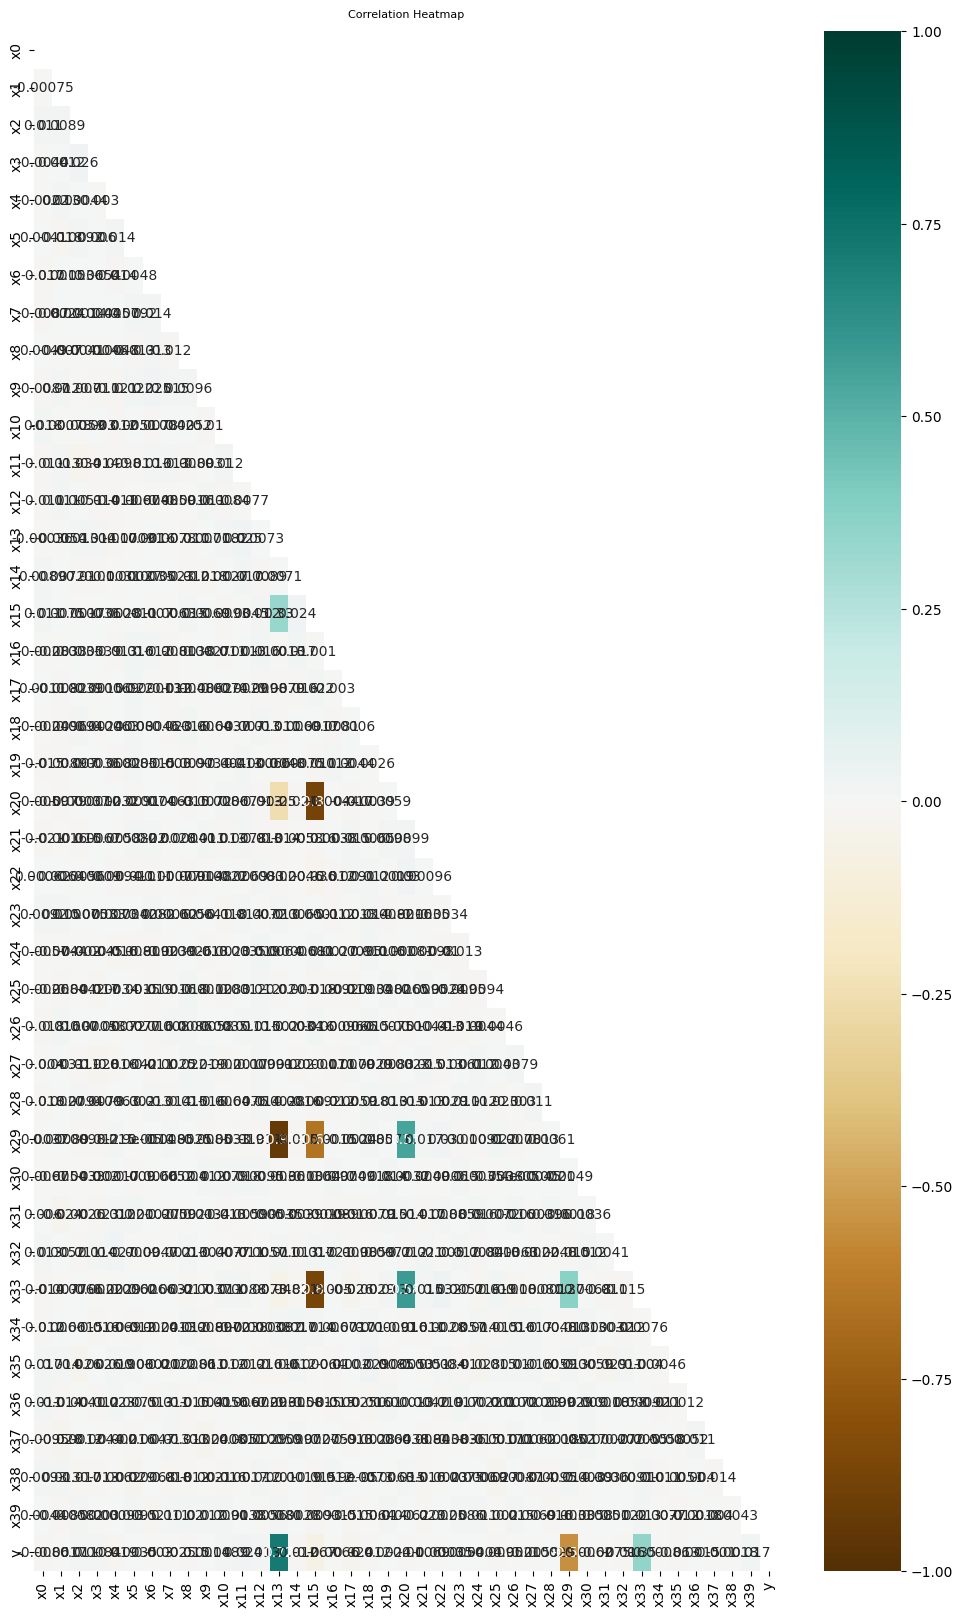

In [13]:
corrmap2(data=df, figx=12, figy=20)

#### Examine mean value of the binary outcome variable for each feature

In [ ]:
binary_means(data=df, feature_group='floats', y_col='y')

### DataProfiler approach

Use the [dataprofiler library](https://pypi.org/project/DataProfiler/) to assess the data.

In [ ]:
data = Data("../data/raw_data.csv")

In [ ]:
print(data.data.head(5)) # Access data directly via a compatible Pandas DataFrame

In [ ]:
profile = Profiler(data) # Calculate Statistics, Entity Recognition, etc

Create a readable report

In [ ]:
readable_report = profile.report(report_options={"output_format": "compact"})

In [ ]:
readable_report

## Use Pandas Profiler

Pandas Profiling is a Python package that can be used to automate EDA. It is an excellent tool for producing reports in an interactive HTML style that makes it simple to read and analyse the data. Let's investigate Pandas Profiling to perform EDA quickly and with just one line of code.With only a few lines of code, you can generate dynamic, interactive collections of exploratory data analysis (EDA) tables and visualisations using the Pandas Profiling Library. 

See Github of Python package [here](https://github.com/ydataai/ydata-profiling)

In [ ]:
from ydata_profiling import ProfileReport

# generate standard profiling report
profile = ProfileReport(df, title="Profiling Report")

## Use Data Prep

The DataPrep library lets you prepare your data using a single library with a few lines of code. One can use DataPrep to: - Collect data from common data sources (through Connector) - Do your exploratory data analysis (through EDA) - Clean and standardize data (through Clean)"DataPrep.Connector" provides an intuitive, open-source API wrapper that speeds up development by standardizing calls to multiple APIs as a simple workflow. Streamline calls to multiple APIs through one intuitive library. It also supports loading data from databases through SQL queries. With one line of code, you can speed up pandas.read_sql by 10X with 3X less memory usage!"DataPrep.EDA" is the fastest and the easiest EDA tool in Python. It allows data scientists to understand a Pandas/Dask DataFrame with a few lines of code in seconds."DataPrep.Clean" aims to provide a large number of functions with a unified interface for cleaning and standardizing data of various semantic types in a Pandas or Dask DataFrame.Here we will keep the scop limited to DataPrep.EDA. See the library documentation [here](https://pypi.org/project/dataprep/).

In [ ]:
from dataprep.eda import create_report

In [ ]:
create_report(df).show_browser()